In [17]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

In [18]:
np.random.seed(42)
n_samples = 5000

x = np.random.uniform(-10,10, n_samples)
y = np.random.uniform(-10,10, n_samples)
z = x**2 + 3*y
df = pd.DataFrame({'x': x, 'y': y, 'z': z})

In [19]:
INPUTS = df.columns.drop('z').tolist()
TARGET = 'z'
X = df[INPUTS]
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['z'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['z'] = y_test

In [23]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create the preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS)
])

# Create the full pipeline with best hyperparameters
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('MLP', MLPRegressor(
        hidden_layer_sizes=(10,),
        activation='tanh',
        alpha=0.001,
        learning_rate_init=0.01,
        solver='adam',
        max_iter=2000,
        tol=1e-4,
        random_state=150,
        verbose=True
    ))
])

# Fit the model
MLP_fit = pipe.fit(X_train[INPUTS], y_train)

Iteration 1, loss = 1119.99935728
Iteration 2, loss = 1078.25172577
Iteration 3, loss = 1017.18971767
Iteration 4, loss = 944.74063957
Iteration 5, loss = 870.36572792
Iteration 6, loss = 804.25704892
Iteration 7, loss = 750.06800711
Iteration 8, loss = 705.58363057
Iteration 9, loss = 666.62681938
Iteration 10, loss = 632.71438613
Iteration 11, loss = 604.21199384
Iteration 12, loss = 581.63065846
Iteration 13, loss = 562.55771715
Iteration 14, loss = 547.48006772
Iteration 15, loss = 534.87221662
Iteration 16, loss = 525.47966386
Iteration 17, loss = 517.63974844
Iteration 18, loss = 510.08136024
Iteration 19, loss = 503.46352822
Iteration 20, loss = 497.89223852
Iteration 21, loss = 492.87711260
Iteration 22, loss = 487.95662949
Iteration 23, loss = 483.78362387
Iteration 24, loss = 480.15815794
Iteration 25, loss = 476.54895168
Iteration 26, loss = 473.66421902
Iteration 27, loss = 470.88015131
Iteration 28, loss = 468.51076912
Iteration 29, loss = 466.23435392
Iteration 30, loss =

In [25]:
dfTR_eval['z_pred'] = MLP_fit.predict(X_train[INPUTS])
dfTS_eval['z_pred'] = MLP_fit.predict(X_test[INPUTS])

In [26]:
print('MLP predictions')
print('Training MAE:',mean_absolute_error(dfTR_eval['z'], dfTR_eval['z_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['z'], dfTS_eval['z_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['z'], dfTR_eval['z_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['z'], dfTS_eval['z_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['z'], dfTR_eval['z_pred']))
print('Test R2:',r2_score(dfTS_eval['z'], dfTS_eval['z_pred']))

MLP predictions
Training MAE: 0.9993978326841321
Test MAE: 1.0104259782478682
Training RMSE: 1.2559159829649464
Test RMSE: 1.241004736021441
Training R2: 0.9986584442545765
Test R2: 0.9986912799084149


MLP_fit

In [32]:
mlp = MLP_fit.named_steps['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity', mlp.get_params()['activation'], mlp.out_activation_]
X = MLP_fit.named_steps['preprocessor'].transform(X_train)
coefnames = MLP_fit.named_steps['preprocessor'].get_feature_names_out(INPUTS)

In [35]:
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=[TARGET])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [36]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y,)

In [37]:
sensmlp.summary()

Sensitivity analysis of [2, 10, 1] MLP network.

Sensitivity measures of each output:

$z 

             mean        std  mean_squared
num__x  -0.413724  63.165863     63.167218
num__y  16.782954   1.149076     16.822245


In [38]:
sensmlp.info()

Sensitivity analysis of [2, 10, 1] MLP network.

4000 samples

Sensitivities of each output (only 5 first samples):

$z 

      num__x     num__y
0  27.282510  15.822991
1 -87.107502  14.218825
2  46.160614  17.464998
3 -87.599325  17.006971
4  53.422979  17.639447


/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


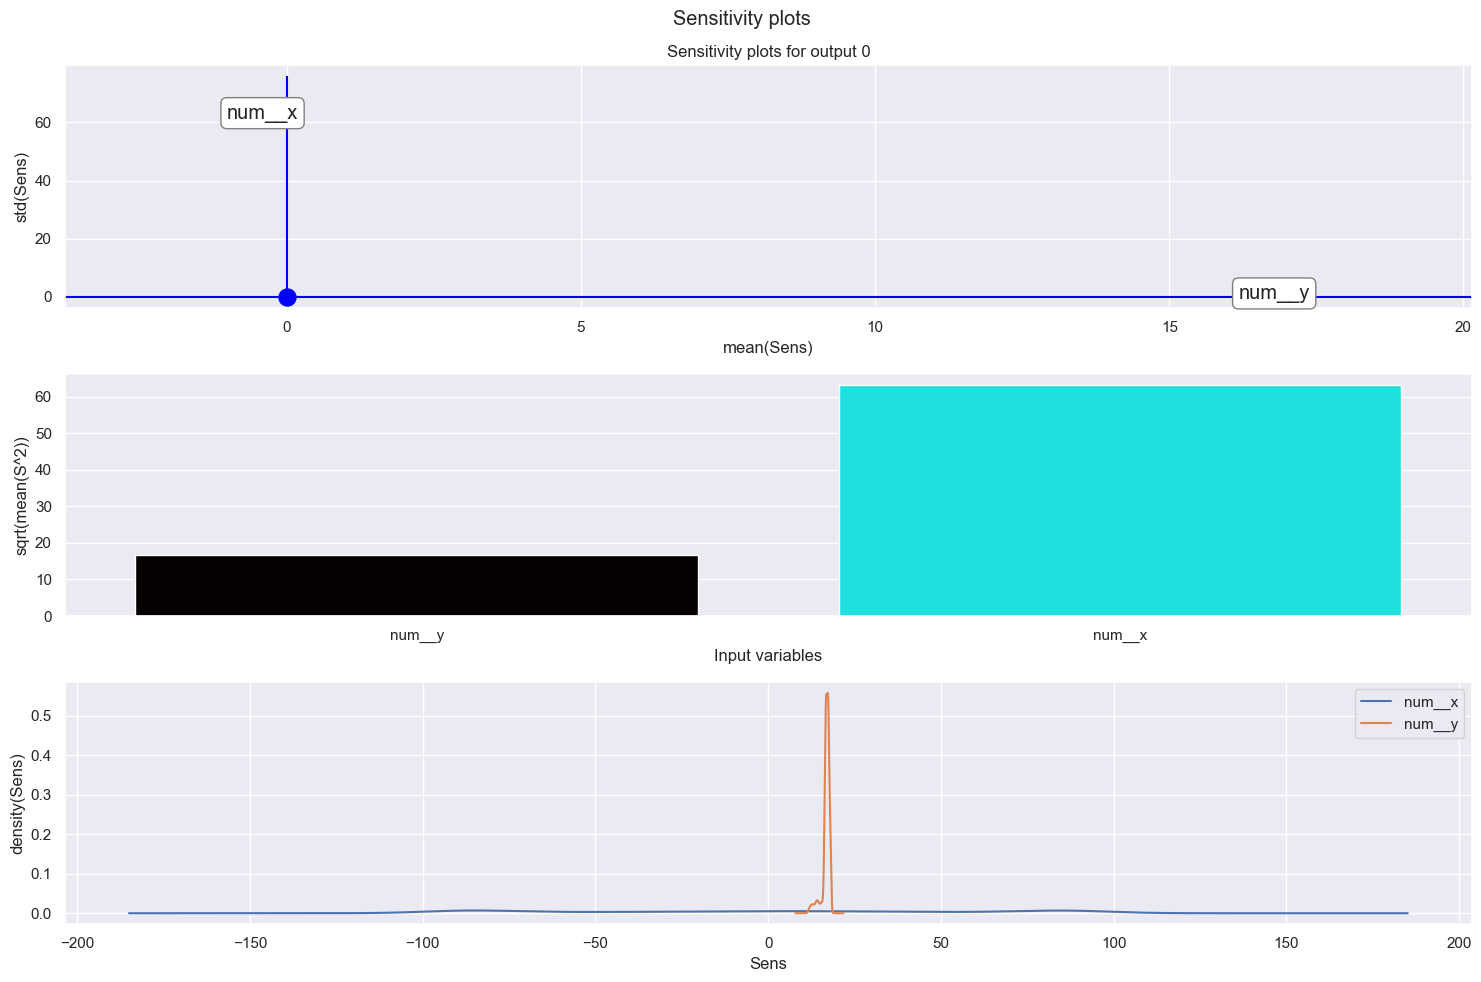

In [39]:
sensmlp.plot()

array([<Axes: xlabel='$\\alpha$', ylabel='$(ms_{X,j}^\\alpha(f))$'>,
       <Axes: >], dtype=object)

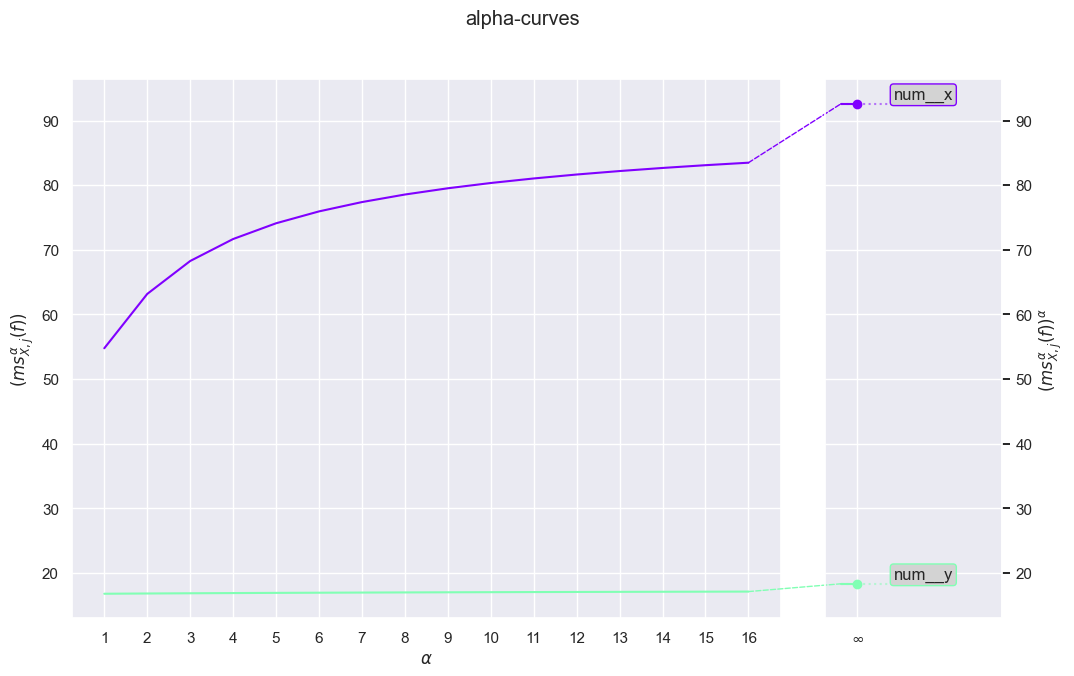

In [40]:
ns.alpha_sens_curves(sensmlp, figsize=(12, 7))

In [41]:
df_partDeriv = sensmlp.raw_sens[0]
df_partDeriv

,num__x,num__y
0,27.282510,15.822991
1,-87.107502,14.218825
2,46.160614,17.464998
3,-87.599325,17.006971
4,53.422979,17.639447
...,...,...
3995,-64.555345,17.474509
3996,-48.181666,18.000766
3997,-18.232375,16.755506
3998,-31.301187,16.509167


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_partial_derivative_distributions(df):
    """
    Dibuja histogramas con líneas de media y mediana para cada derivada parcial desescalada.
    
    Args:
        df (pd.DataFrame): DataFrame con columnas como num__S_descale, num__K_descale, etc.
    """
    # Filtramos solo columnas desescaladas
    cols = [col for col in df.columns if col.startswith('num__')]
    
    n_cols = len(cols)
    n_rows = (n_cols + 1) // 2  # dos columnas por fila
    
    plt.figure(figsize=(14, 5 * n_rows))
    
    for i, column in enumerate(cols, 1):
        plt.subplot(n_rows, 2, i)
        sns.histplot(df[column], kde=True, bins=100, color='steelblue')
        plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Mean: {df[column].mean():.2f}")
        plt.axvline(df[column].median(), color='green', linestyle=':', label=f"Median: {df[column].median():.2f}")
        
        # Extraemos el nombre original de la variable (S, K, T, sigma)
        feature_name = column.split('__')[-1].replace('_descale','')
        plt.title(f"∂Price/∂{feature_name}")
        
        plt.xlabel("Partial derivative value")
        plt.ylabel("Frequency")
        plt.legend()
    
    plt.tight_layout()
    plt.show()

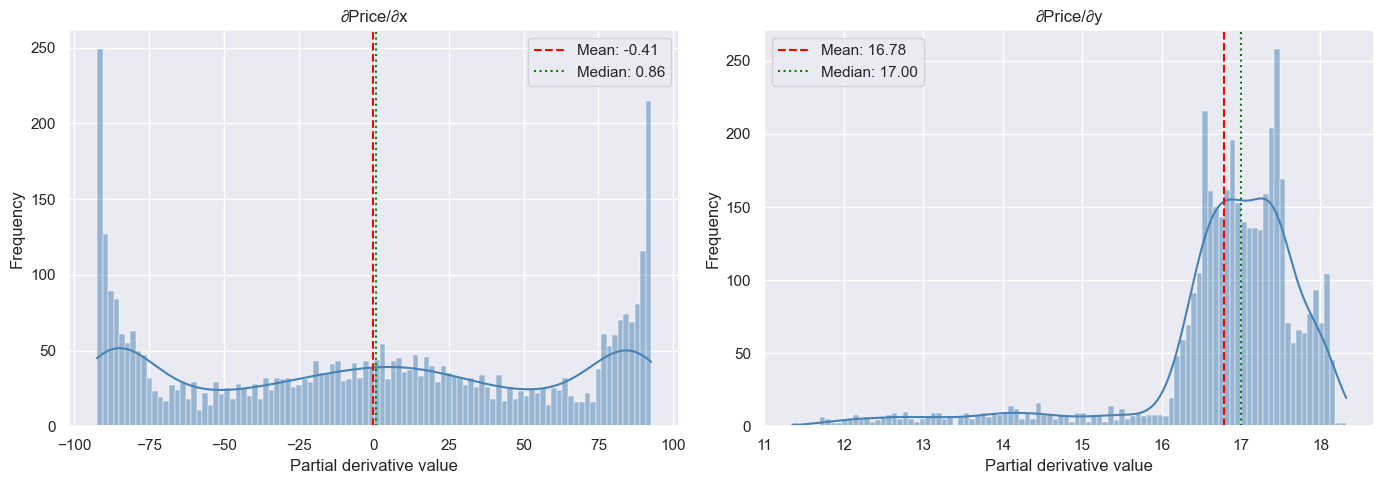

In [43]:
plot_partial_derivative_distributions(df_partDeriv)

## Desescalar

In [44]:
# Obtenemos el scaler de tu pipeline
scaler = MLP_fit.named_steps['preprocessor'].transformers_[0][1].named_steps['scaler']
scales = scaler.scale_

# Las columnas de neuralsens para tu dataset sintético
columns = ['num__x', 'num__y']

# Desescalamos las derivadas
for i, col in enumerate(columns):
    df_partDeriv[col + '_descaled'] = df_partDeriv[col] / scales[i]

In [45]:
df_partDeriv.describe()
df_partDeriv

,num__x,num__y,num__x_descaled,num__y_descaled
0,27.282510,15.822991,4.703837,2.770277
1,-87.107502,14.218825,-15.018396,2.489421
2,46.160614,17.464998,7.958653,3.057758
3,-87.599325,17.006971,-15.103192,2.977567
4,53.422979,17.639447,9.210773,3.088301
...,...,...,...,...
3995,-64.555345,17.474509,-11.130129,3.059423
3996,-48.181666,18.000766,-8.307107,3.151560
3997,-18.232375,16.755506,-3.143484,2.933541
3998,-31.301187,16.509167,-5.396706,2.890412


In [47]:
df_partDeriv.mean()

num__x             -0.413724
num__y             16.782954
num__x_descaled    -0.071331
num__y_descaled     2.938347
dtype: float64

In [48]:
df_partDeriv.median()

num__x              0.862188
num__y             16.995792
num__x_descaled     0.148652
num__y_descaled     2.975610
dtype: float64